In [38]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
from math import sqrt
from joblib import Parallel, delayed
nn = Parallel(n_jobs=2)(delayed(sqrt)(i ** 10) for i in range(100000))


In [16]:
import gadget_reader as gd
import time_conversion as tiempo
from joblib import Parallel, delayed

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#------------------------------------------------------------------------
vector2 = ('M31', 'MW', 'M33')

path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram_4096/'

aa = np.loadtxt(path2 + 'redshift_outputs.txt')
aexp  = aa[:,2]

path  = '/srv/cosmdatc/clues/B64_WM3_186592/LG/GAS_SFR/4096/SNAPS/snap_'


# def sarasa(l):
for l in range(0,3):
    
    file = np.loadtxt(path2 + str('%s'%vector2[l]) +'_tform_z0.dat')
    ID    = file[:,0]
    tform = file[:,2]
    
    sort = np.argsort(tform)
    
    sort_tform = tform[sort][::-1]
    sort_ID    = ID[sort][::-1]
    
    file2 = np.loadtxt(path2 +  str('%s'%vector2[l]) +'_masscenter.dat')
    time = file2[:,0]
    xcm  = file2[:,1]
    ycm  = file2[:,2]
    zcm  = file2[:,3]
    
    
    time_aux = np.zeros(len(ID))

    k = 1
    
    for i in range(0,len(ID)):
        if sort_tform[i] > time[0]:
            time_aux[i] = time[0]
            continue
            
        if sort_tform[i] < time[-1]:
            time_aux[i] = time[-1]
            continue
            
        for j in range(k, len(time)):
            
            if  sort_tform[i] > time[j]:
                time_aux[i] = time[j-1]
    #             print time_aux[i]
                if time_aux[i] < time_aux[i-1]:
                    k = k + 1
                break

    isnap = np.arange(496,0,-1)
    
    archivo = open(path2 + str('%s'%vector2[l]) + '_tform_particles.dat', 'a')

    for i in range(0, len(time)):

        mask, = np.where(time_aux == time[i])

        if len(mask) == 0:
            continue  # el break sale del for loop
                
        sim = gd.Open(path + str('%03d'%isnap[i]), endian='Big', gadget_type=2, verbose=False)

        pstr = sim.Read('POS ',4)
        IDs  = sim.Read('ID  ',4)
        tf   = sim.Read('AGE ',4)

        z   = a0/tf - 1.
        Ht  = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        tf2 = tiempo.conv(z, h, omega_lambda, omega_matter)


        particles = np.isin(IDs, sort_ID[mask])


        xstr = (pstr[0,:][particles]-xcm[i])*aexp[isnap[i]]/h
        ystr = (pstr[1,:][particles]-ycm[i])*aexp[isnap[i]]/h
        zstr = (pstr[2,:][particles]-zcm[i])*aexp[isnap[i]]/h

        rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)

        data = np.ndarray([len(mask), 3])
        data[:,0] = IDs[particles]
        data[:,1] = rstr
        data[:,2] = tf2[particles]
        
        np.savetxt(archivo, data, fmt=('%15d','%12.6f','%12.6f'))
        
    archivo.close()

            


In [17]:
with Parallel(n_jobs=3, prefer="threads") as par:
    par(delayed(sarasa)(ll)for ll in range(0,3))
    


In [42]:
path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram_4096/'
M31gd = np.loadtxt(path2 + 'M31_tform_particles.dat')
ID_M31 = M31gd[:,0]
r_M31  = M31gd[:,1]
tf_M31 = M31gd[:,2]

M31gd = np.loadtxt(path2 + 'M31_part_barra.dat')
Ids  = M31gd[:,0]


mask = np.isin(ID_M31, Ids)

In [43]:
num_M31 = np.where(r_M31< 15.)

p1 = len(r_M31[num_M31])/float(len(r_M31))
print p1, 1-p1

bar_num = np.where(r_M31[mask]<2.5)
p2 = len(r_M31[mask][bar_num])/float(len(r_M31[mask]))
print p2, 1-p2


print len(r_M31[mask])/float(len(r_M31))

0.720032506191 0.279967493809
0.931866294369 0.0681337056311
0.422374491242


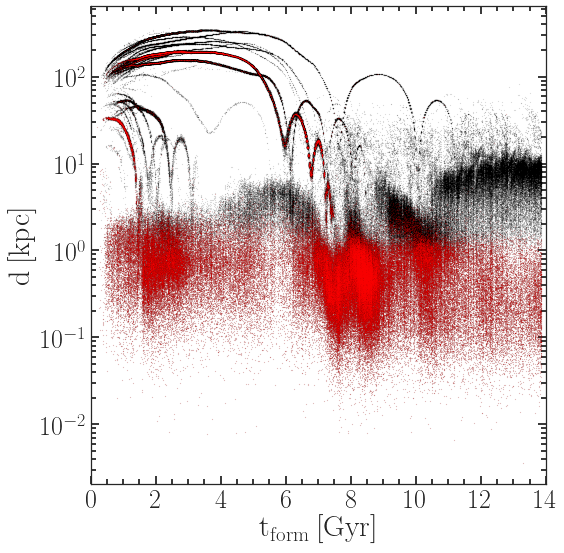

In [44]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
fig.patch.set_facecolor('white')
ax.plot(tf_M31 ,r_M31,'.k', markersize=0.1)
ax.plot(tf_M31[mask] ,r_M31[mask],'.r', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
# ax.set_ylim(0,0.7)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()

In [45]:
MWgd = np.loadtxt(path2 + 'MW_tform_particles.dat')
ID_MW = MWgd[:,0]
r_MW  = MWgd[:,1]
tf_MW = MWgd[:,2]


In [46]:
num_MW = np.where(r_MW< 15.)

p1 = len(r_MW[num_MW])/float(len(r_MW))
print p1, 1-p1

0.470137325825 0.529862674175


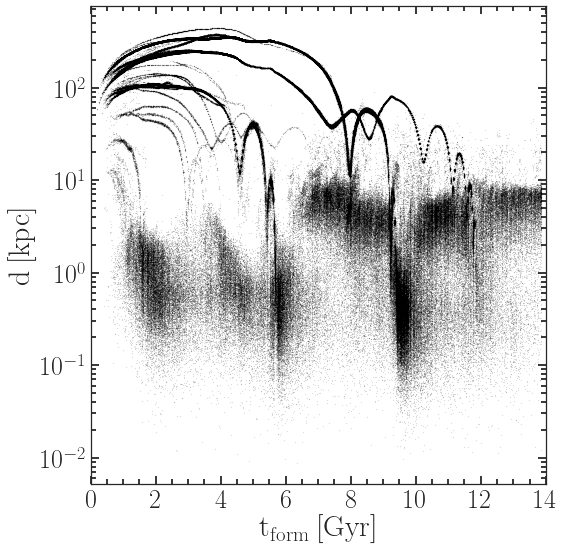

In [47]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
fig.patch.set_facecolor('white')
ax.plot(tf_MW ,r_MW,'.k', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
# ax.set_ylim(0,0.7)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()

In [48]:
M33gd = np.loadtxt(path2 + 'M33_tform_particles.dat')
ID_M33 = M33gd[:,0]
r_M33  = M33gd[:,1]
tf_M33 = M33gd[:,2]


In [49]:
num_M33 = np.where(r_M33< 15.)

p1 = len(r_M33[num_M33])/float(len(r_M33))
print p1, 1-p1

0.809649888101 0.190350111899


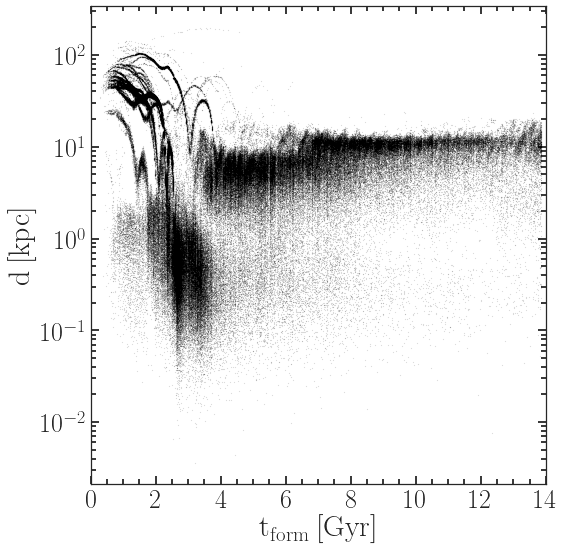

In [50]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
# plt.style.use('seaborn-ticks') 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
fig.patch.set_facecolor('white')
ax.plot(tf_M33 ,r_M33,'.k', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
# ax.set_ylim(0,0.7)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()